# Setup

In [58]:
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sbn

from numpy.random import seed
import numpy as np

# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx


## LA Times Census Tracts

* [Download the data](http://boundaries.latimes.com/sets/)

In [2]:
# get neighborhood boundaries from the LA Times
# neighborhoods = gpd.read_file('http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v5.geojson')

In [3]:
# get census tract boundaries from the LA Times
tracts = gpd.read_file('http://boundaries.latimes.com/1.0/boundary-set/census-tracts-2012/?format=geojson')

In [4]:
# trim the data to the bare minimum columns
tracts = tracts[['name','geometry']]
tracts.head()

,name,geometry
0,06037101110,"MULTIPOLYGON (((-118.30229 34.25870, -118.3007..."
1,06037101122,"MULTIPOLYGON (((-118.30333 34.27354, -118.3031..."
2,06037101210,"MULTIPOLYGON (((-118.29945 34.25598, -118.2859..."
3,06037101220,"MULTIPOLYGON (((-118.28592 34.24896, -118.2859..."
4,06037101300,"MULTIPOLYGON (((-118.27247 34.23253, -118.2719..."


In [5]:
# get the layers into a web mercator projection
# reproject to web mercator
tracts = tracts.to_crs(epsg=3857)

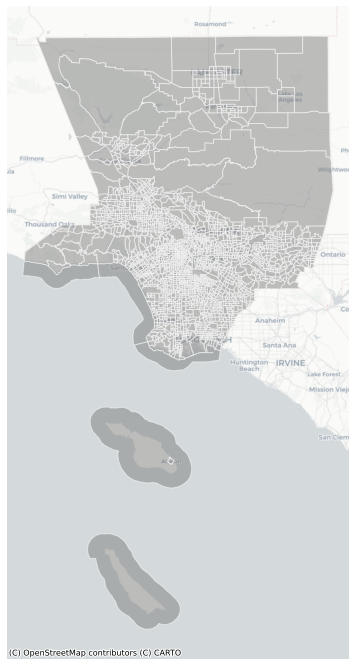

In [6]:
# plot it!
ax=tracts.plot(figsize=(12,12),
                      color='gray', 
                      edgecolor='white',
                      alpha=0.5)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


## Get Arrest Data from LA Open Data Portal
Next, we acquire the data using the socrata API. Use the socrata documentation to grab the code syntax for our arrests data.
- https://dev.socrata.com/foundry/data.lacity.org/amvf-fr72

In [7]:
import pandas as pd
import plotly.express as px
from sodapy import Socrata

In [8]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

results = client.get("amvf-fr72", 
                     limit=50000,
                     where = "arst_date between '2020-03-01T00:00:00' and '2020-09-30T00:00:00'",
                     order='arst_date desc')

# Convert to pandas DataFrame
arrests = pd.DataFrame.from_records(results)


In [9]:
arrests.shape

(36216, 25)

## Convert data to a geodataframe

Geopandas allows us to convert different types of data into a spatial format.
- https://geopandas.org/gallery/create_geopandas_from_pandas.html

In [10]:
# convert pandas dataframe to geodataframe
arrests = gpd.GeoDataFrame(arrests, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(arrests.lon, arrests.lat))

In [11]:
# get the layers into a web mercator projection
# reproject to web mercator
arrests = arrests.to_crs(epsg=3857)

In [12]:
arrests.lon = arrests.lon.astype('float')

In [13]:
arrests.lat = arrests.lat.astype('float')

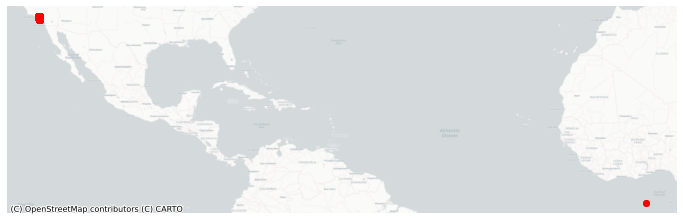

In [14]:
# map it!
ax = arrests.plot(figsize=(12,12),color='red')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


In [15]:
arrests[arrests.lon==0]

,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,descent_cd,...,location,lat,lon,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst,geometry
18173,5951250,BOOKING,2020-06-09T00:00:00.000,0025,06,Hollywood,0665,39,M,O,...,FOUNTAIN,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",2020-06-09T00:00:00.000,0224,HOLLYWOOD,4206,MACCADEN,POINT (0.00000 0.00000)
26040,5921308,BOOKING,2020-04-26T00:00:00.000,1500,19,Mission,1942,25,M,H,...,REGAN FY,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",2020-04-26T00:00:00.000,1631,VALLEY - JAIL DIV,4279,LAUREL CANYON BL,POINT (0.00000 0.00000)


In [16]:
# drop the unmapped rows
arrests.drop(arrests[arrests.lon==0].index,inplace=True)

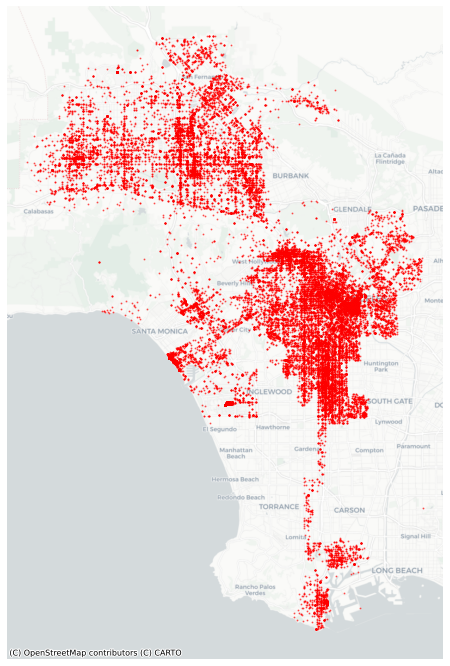

In [17]:
# map it!
ax = arrests.plot(figsize=(12,12),color='red',markersize=1,alpha=0.5)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


## Create a two layer map

- https://geopandas.org/mapping.html

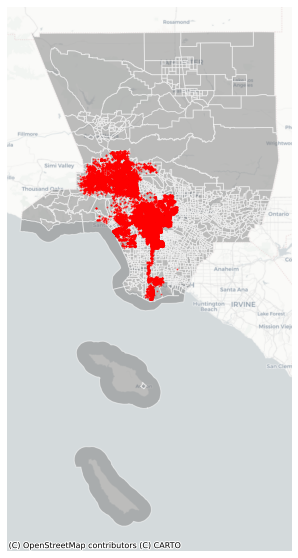

In [18]:
# first define which layers will be your "base"
base = tracts.plot(figsize=(12,10),
                      color='gray', 
                      edgecolor='white',
                      alpha=0.5)

# define the layer that will go on top, and add the base layer to the `ax` argument
ax = arrests.plot(ax=base, color='red',markersize=1,alpha=0.5)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


## Zoom to the points, not the neighborhoods

By default, the map has zoomed out to fit both layers. Sometimes, we may want to zoom to the extent of a smaller layer, in this case, the crime data.

In [19]:
# get the bounding box coordinates for the crime data
arrests.geometry.total_bounds

array([-13209059.45803905,   3989526.81108362, -13153388.58069333,
         4072889.46565252])

In [20]:
# shortcut to put them into their own variables
minx, miny, maxx, maxy = arrests.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)


-13209059.458039049
-13153388.580693332
3989526.8110836204
4072889.465652517


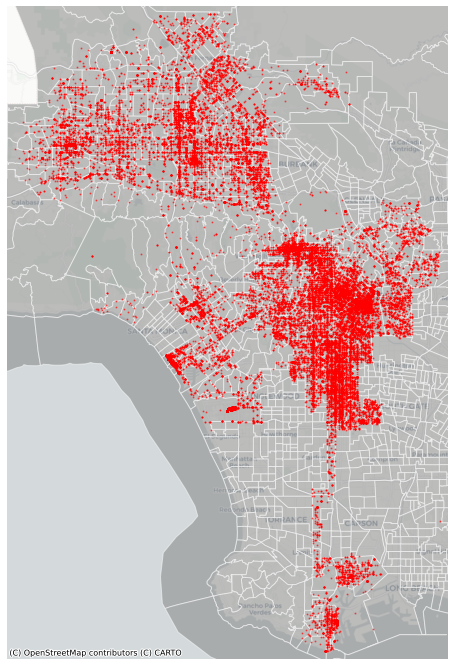

In [21]:
# use the bounding box coordinates to set the x and y limits
base = tracts.plot(figsize=(12,12),
                          color='gray', 
                          edgecolor='white',
                          alpha=0.5)

ax = arrests.plot(ax=base, 
                color='red',markersize=1,alpha=0.5)

ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

ax

## The spatial join

* https://geopandas.org/mergingdata.html?highlight=spatial%20join

In a Spatial Join, two geometry objects are merged based on their spatial relationship to one another.

The how argument specifies the type of join that will occur and which geometry is retained in the resultant geodataframe. It accepts the following options:

`left`: use the index from the first (or left_df) geodataframe that you provide to sjoin; retain only the left_df geometry column

`right`: use index from second (or right_df); retain only the right_df geometry column

`inner`: use intersection of index values from both geodataframes; retain only the left_df geometry column



In [22]:
# Do the spatial join
join = gpd.sjoin(tracts,
                 arrests,
                 how='right')

Next, we create a dataframe that counts crime by neighborhood:

In [23]:
arrests_by_tracts = join.name.value_counts().rename_axis('name').reset_index(name='arrests_count')

In [24]:
arrests_by_tracts.head()

,name,arrests_count
0,06037980028,705
1,06037206300,477
2,06037237600,440
3,06037273402,405
4,06037208801,357


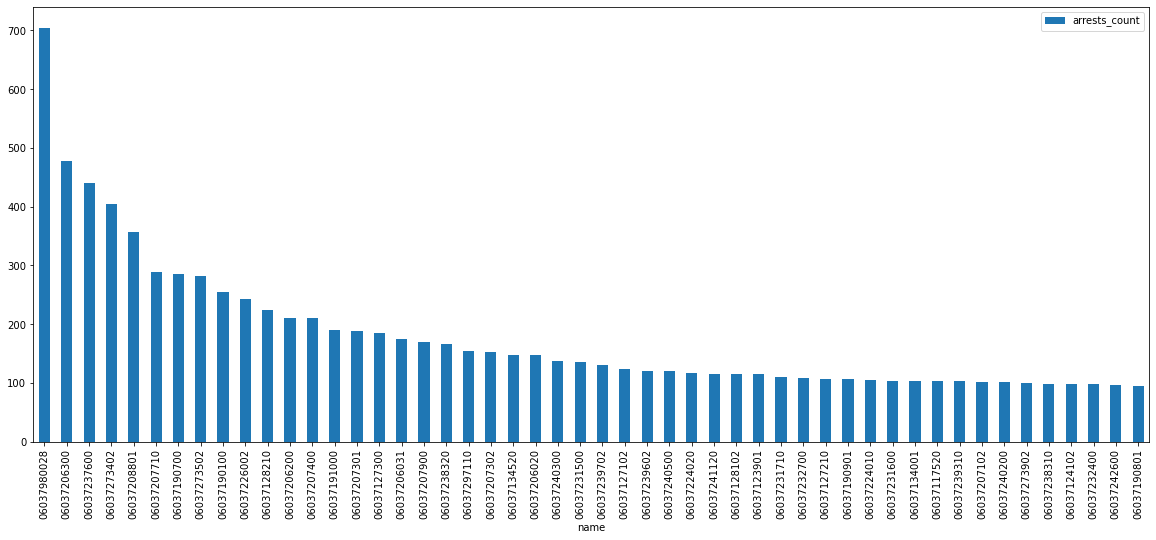

In [25]:
# make a bar chart
arrests_by_tracts[:50].plot.bar(figsize=(20,8),x='name',y='arrests_count')

## Join the value counts back to the neighborhoods

The bar chart is nice, but what we also want is a choropleth map to accompany it. To do so, we merge the counts back to the neighborhoods.

In [26]:
# join the summary table back to the neighborhood geodatabase
tracts=tracts.merge(arrests_by_tracts,on='name')

In [27]:
# our neighborhood table now has a count column
tracts.head()

,name,geometry,arrests_count
0,06037101110,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",14
1,06037101122,"MULTIPOLYGON (((-13169466.900 4065590.632, -13...",7
2,06037101210,"MULTIPOLYGON (((-13169034.646 4063225.625, -13...",28
3,06037101220,"MULTIPOLYGON (((-13167528.828 4062280.326, -13...",20
4,06037101300,"MULTIPOLYGON (((-13166031.469 4060067.620, -13...",7


## Map neighborhoods by crime count

In [28]:
# reproject to web mercator
tracts = tracts.to_crs(epsg=3857)

In [29]:
# reproject to web mercator
arrests = arrests.to_crs(epsg=3857)

In [30]:
# shortcut to put them into their own variables
minx, miny, maxx, maxy = arrests.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13209059.458039049
-13153388.580693332
3989526.8110836204
4072889.465652517


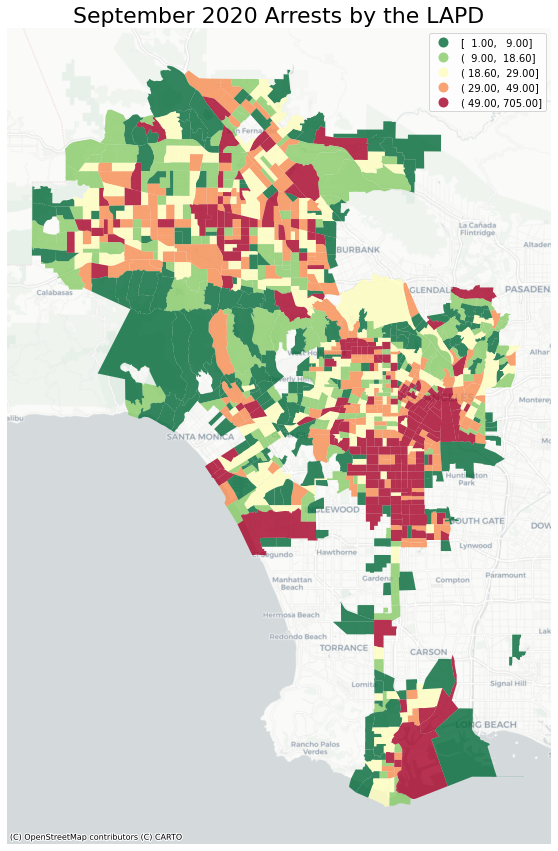

In [31]:
ax = tracts.plot(figsize=(15,15),
                        column='arrests_count',
                        legend=True,
                        alpha=0.8,
                        cmap='RdYlGn_r',scheme='quantiles')

ax.axis('off')
ax.set_title('September 2020 Arrests by the LAPD',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Spatial Autocorrelation

## Spatial Weights and Spatial Lag
Spatial weights are how we determine the area’s neighborhood. There are different statistical methods that are used for determining spatial weights, and it is beyond this to provide an in-depth explanation of each in this article. One of the most commonly used spatial weights methods is Queen Contiguity Matrix, which we use. Here is a diagram explaining how the Queen contiguity matrix works ( included also is the rook contiguity matrix)

![Queen](https://www.researchgate.net/profile/Matthew_Tenney/publication/304782766/figure/fig8/AS:380175423426567@1467652292591/Rooks-vs-Queens-Contiguity.png)


## Spatial weight

In [32]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(tracts,k=8)
wq.transform = 'r'

In [33]:
# calculate spatial weight
# wq =  lps.weights.Queen.from_dataframe(tracts,idVariable='name')
# wq.transform = 'r'

Uh oh, we have warnings! It looks like some geographies are problematic. Let's find out what's going on.

In [34]:
# where are the error locations?
no_neighbors=tracts.loc[tracts.name.isin(['06037535606','06037571400','06037601600'])]

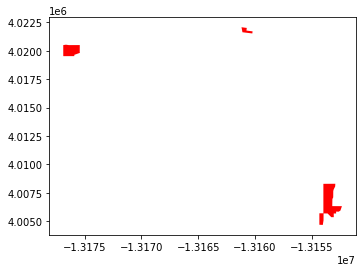

In [35]:
no_neighbors.plot(color='red')

And where are these problem geographies?

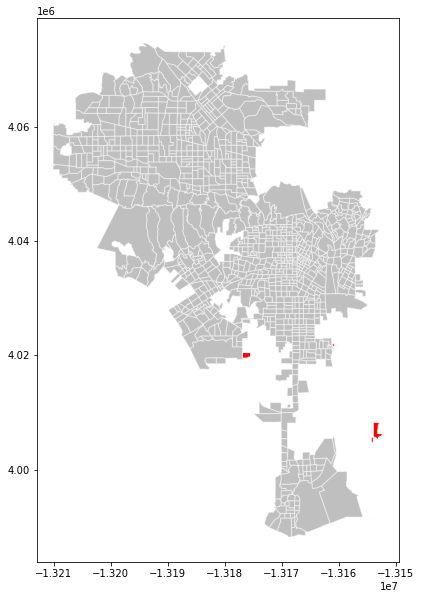

In [36]:
# first define which layers will be your "base"
base = tracts.plot(figsize=(12,10),
                      color='gray', 
                      edgecolor='white',
                      alpha=0.5)

# define the layer that will go on top, and add the base layer to the `ax` argument
ax = no_neighbors.plot(ax=base, color='red',edgecolor='white',)

In [37]:
# drop the problematic geographies
tracts.drop(tracts.loc[tracts.name.isin(['06037535606','06037571400','06037601600'])].index,inplace=True)

In [38]:
# apply weight again
# wq =  lps.weights.Queen.from_dataframe(tracts,idVariable='name')
# wq.transform = 'r'

In [39]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(tracts,k=8)
wq.transform = 'r'

## Spatial lag

In [40]:
# create a new column for lag
tracts['arrests_count_lag'] = lps.weights.lag_spatial(wq, tracts['arrests_count'])

In [41]:
tracts.sample(20)

,name,geometry,arrests_count,arrests_count_lag
1005,06037600912,"MULTIPOLYGON (((-13174480.841 4024969.237, -13...",11,29.000
274,06037134201,"MULTIPOLYGON (((-13202215.647 4057049.409, -13...",49,38.375
538,06037207301,"MULTIPOLYGON (((-13164323.049 4034580.428, -13...",188,200.750
331,06037141202,"MULTIPOLYGON (((-13185743.034 4048605.809, -13...",7,14.375
802,06037240600,"MULTIPOLYGON (((-13165943.193 4021130.622, -13...",62,71.875
403,06037189600,"MULTIPOLYGON (((-13173147.679 4042997.615, -13...",32,89.875
551,06037208502,"MULTIPOLYGON (((-13166487.879 4037928.764, -13...",30,82.375
957,06037294620,"MULTIPOLYGON (((-13163928.421 3999764.396, -13...",20,33.375
58,06037107010,"MULTIPOLYGON (((-13186259.111 4069642.114, -13...",12,22.625
644,06037217200,"MULTIPOLYGON (((-13174580.695 4035246.658, -13...",51,28.750


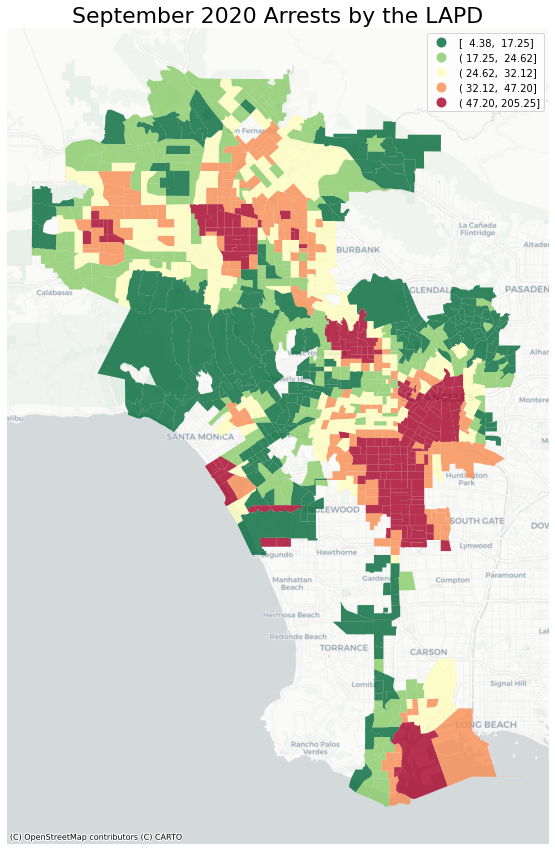

In [42]:
ax = tracts.plot(figsize=(15,15),
                        column='arrests_count_lag',
                        legend=True,
                        alpha=0.8,
                        cmap='RdYlGn_r',scheme='quantiles')

ax.axis('off')
ax.set_title('September 2020 Arrests by the LAPD',fontsize=22)
# ax = arrests.plot(ax=ax, color='blue',markersize =1,alpha=0.2, legend=True)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

We can now compare these two map outputs side by side. Notice that the syntax is a bit different from past labs where we have only worked with one figure at a time. This output produces 1 row, and 2 columns of figures called `subplots`.

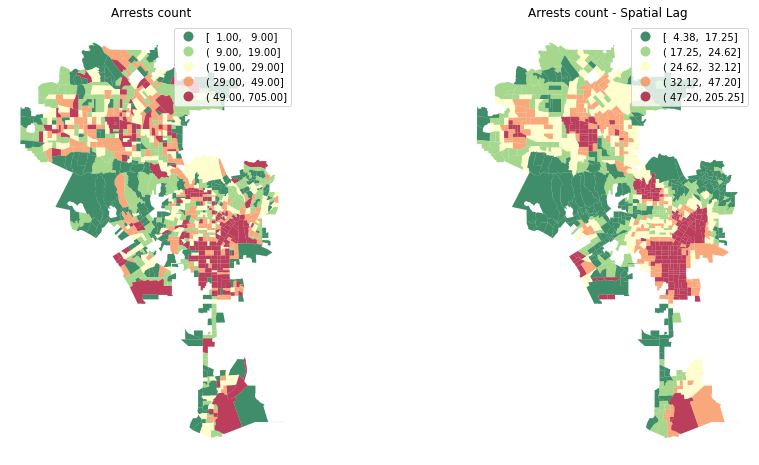

In [99]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
tracts.plot(column='arrests_count', 
            cmap='RdYlGn_r', 
            scheme='quantiles',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            legend=True, 
            ax=ax1 # this assigns the map to the subplot
           )


ax1.axis("off")
ax1.set_title("Arrests count")

# spatial lag map on the right
tracts.plot(column='arrests_count_lag', 
            cmap='RdYlGn_r', 
            scheme='quantiles',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            legend=True, 
            ax=ax2 # this assigns the map to the subplot
           )

ax2.axis("off")
ax2.set_title("Arrests count - Spatial Lag")

plt.show()

In [44]:
# what is the median number of arrests per neighborhood?
median = tracts.arrests_count.median()
median

23.0

In [45]:
# visualize as a binary
tracts['above_arrest_median'] = (tracts['arrests_count'] > median).astype(int)

In [46]:
tracts.head()

,name,geometry,arrests_count,arrests_count_lag,above_arrest_median
0,06037101110,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",14,14.500,0
1,06037101122,"MULTIPOLYGON (((-13169466.900 4065590.632, -13...",7,14.625,0
2,06037101210,"MULTIPOLYGON (((-13169034.646 4063225.625, -13...",28,13.250,1
3,06037101220,"MULTIPOLYGON (((-13167528.828 4062280.326, -13...",20,14.250,0
4,06037101300,"MULTIPOLYGON (((-13166031.469 4060067.620, -13...",7,15.875,0


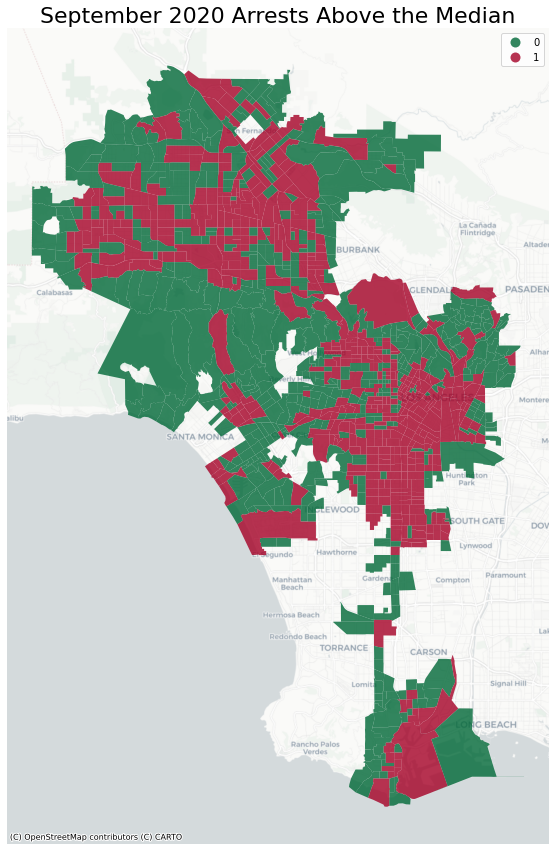

In [47]:
ax = tracts.plot(figsize=(15,15),
                        column='above_arrest_median',
                        legend=True,
                        alpha=0.8,
                        cmap='RdYlGn_r',
                        categorical=True,)

ax.axis('off')
ax.set_title('September 2020 Arrests Above the Median',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Moran's I

In [48]:
y = tracts.arrests_count
moran = Moran(y, wq)
moran.I

0.2502081223860579

The other bit of information we will extract from Moran’s I relates to statistical inference: how likely is the pattern we observe in the map and Moran’s I captures in its value to be generated by an entirely random process? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics? To obtain insight into these questions, PySAL performs a simulation and returns a measure of certainty about how likely it is the pattern we observe in our dataset came from a spatially random process. This is summarised in the p_sim attribute:

In [49]:
moran.p_sim

0.001

The value is calculated as an empirical P-value that represents the proportion of realisations in the simulation under spatial randomness that are more extreme than the observed value. A small enough p-value associated with the Moran’s I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern than we would expect if the values had been randomly allocated to a locations.

That is a very low value, particularly considering it is actually the minimum value we could have obtained given the simulation behind it used 999 permutations (default in PySAL) and, by standard terms, it would be deemed statistically significant. We can ellaborate a bit further on the intuition behind the value of p_sim. If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran’s I statistic for each of those maps, only 0.01% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.99% of the random maps would receive a smaller (absolute) value of Moran’s I. If we remember again that the value of Moran’s I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values over space we observe for the percentage of Leave votes is more concentrated than if we were to randomly shuffle the vote proportions among the map, hence the statistical significance. As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively autocorrelated over space. Indeed, the overall spatial pattern in the EU Referendum vote was highly marked: nearby areas tended to vote alike.

Thanks to the splot visualisation module in PySAL, we can obtain a quick representation of the statistic that combines the Moran Plot (right) with a graphic of the empirical test that we carry out to obtain p_sim (left):

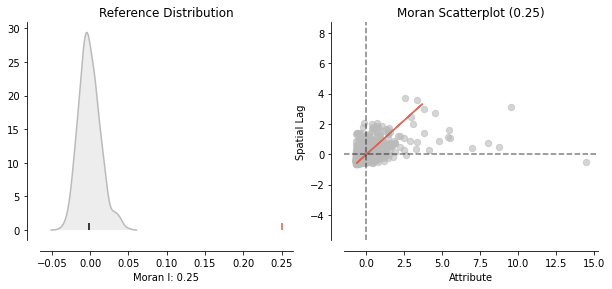

In [50]:
plot_moran(moran);

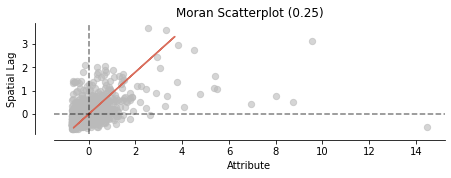

In [64]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [52]:
lisa = esda.moran.Moran_Local(y, wq)

- https://pysal.org/esda/generated/esda.Moran_Local.html

In [54]:
# how many per quadrant?
counts = [(j,(lisa.q==j).sum()) for j in range(1,5)]
counts

[(1, 210), (2, 150), (3, 553), (4, 134)]

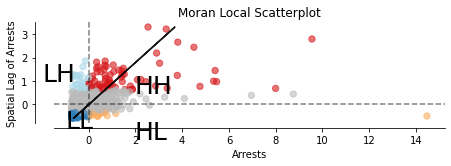

In [55]:
# Plot
fig, ax = moran_scatterplot(lisa, p=0.05)
ax.set_xlabel("Arrests")
ax.set_ylabel('Spatial Lag of Arrests')
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

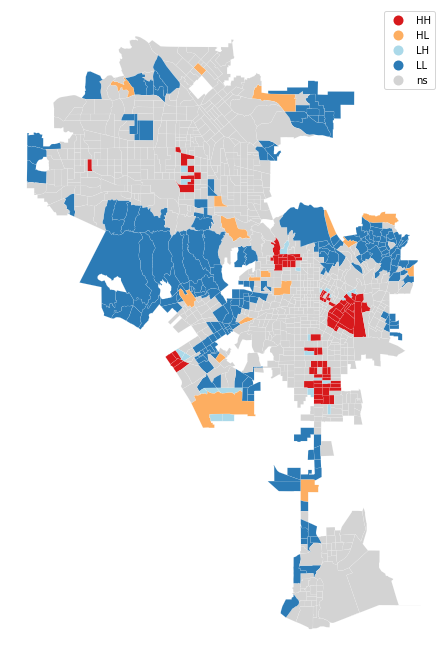

In [65]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, tracts, p=0.05, figsize = (16,12),ax=ax)
plt.show()

The correspondence between the numbers in the q attribute and the actual quadrants is as follows:

1: HH

2: LH

3: LL

4: HL

In [68]:
# original df... how many rows?
len(tracts)

1047

In [86]:
tracts.head()

,name,geometry,arrests_count,arrests_count_lag,above_arrest_median,p_sim,q
0,06037101110,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",14,14.500,0,0.022,3
1,06037101122,"MULTIPOLYGON (((-13169466.900 4065590.632, -13...",7,14.625,0,0.024,3
2,06037101210,"MULTIPOLYGON (((-13169034.646 4063225.625, -13...",28,13.250,1,0.016,3
3,06037101220,"MULTIPOLYGON (((-13167528.828 4062280.326, -13...",20,14.250,0,0.021,3
4,06037101300,"MULTIPOLYGON (((-13166031.469 4060067.620, -13...",7,15.875,0,0.030,3


In [75]:
# original value list
lisa.y[:5]

array([14,  7, 28, 20,  7])

In [79]:
# quadrant list
lisa.q[:5]

array([3, 3, 3, 3, 3])

In [80]:
# p sim list
lisa.p_sim[:5]

array([0.022, 0.024, 0.016, 0.021, 0.03 ])

In [85]:
# add it to the dataframe
tracts['q'] = lisa.q.tolist()

In [83]:
# add it to the dataframe
tracts['p_sim'] = lisa.p_sim.tolist()

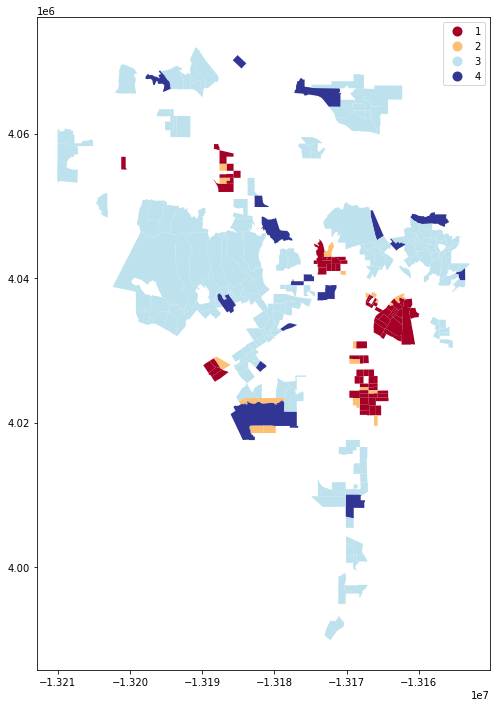

In [96]:
tracts[tracts.p_sim < 0.05].plot(figsize=(12,12),column='q',legend=True,categorical=True,cmap='RdYlBu')

# Resources

- https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html
- https://pysal.org/esda/notebooks/spatialautocorrelation.html
- https://towardsdatascience.com/what-is-exploratory-spatial-data-analysis-esda-335da79026ee